# Clasificación de audio utilizando embeddings de YAMNet

En este notebook revisaremos una de las tantas técnicas para el procesamiento de audio: embeddings

## Preparacion del ambiente

Instalamos las librerias necesarias: `librosa`, `moviepy` y `soundfile`

In [15]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/audio/neural/yamnet_class.txt \
    --quiet --no-clobber
!pip install -r yamnet_class.txt --quiet

Descargamos algunas utilidades para graficar audio y el mapa de etiquetas de las predicciones del modelo:

In [16]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/Models/yamnet/yamnet_class_map.csv \
    --directory-prefix ./Models/yamnet/ --quiet --no-clobber
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/m72109/audio/plotting.py \
    --directory-prefix ./m72109/audio/ --quiet --no-clobber

Descargamos algunos archivos de audio de ejemplo

In [17]:
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/Samples/127_hours_285_295_2.wav \
  --directory-prefix ./Samples/ --quiet
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/Samples/Back_To_The_Future_3648_3658_6.wav \
  --directory-prefix ./Samples/ --quiet

## Classificación de audio utilizando CNNs

La performance de los modelos de clasificación de imágenes ha mejorado enormemente con la utilización de grandes conjuntos de datos como ImageNet, lo que permite utilizar grandes arquitecturas de redes neuronales basadas en convoluciones (CNN) como AlexNet, VGG, Inception y ResNet. Justamente de este último tipo hemos visto un ejemplo de como utilizar un modelo preentrenado en ImageNet para transferir los conceptos aprendidos a otro dominio. ¿Sería posible entonces pensar que la misma ténica podría funcionar para la clasificación de audio?

### AudioSet-YouTube corpus

Equivalente a ImageNet, existe un dataset de un gran tamaño sobre el cual entrenar modelos especificamente tratandose de audio. Este conjunto de datos, AudioSet-YouTube corpus consta de una colección de 2,084,320 clips de sonido de 10 segundos con etiquetas (labels) extraídas de videos de YouTube. Estas anotaciones corresponden a 632 diferentes clases que se especifican como un gráfico jerárquico de categorías de eventos, que cubre una amplia gama de sonidos incluyendo anumales, personas, instrumentos musicales y géneros, y sonidos ambientales de la vida cotidiana.

Para más información sobre este set de datos pueden visitar: https://research.google.com/audioset/

### YAMNet 

YAMNet es un modelo que explota las técnicas de Computer Vision al construir imagenes a partir de audio (llamados parches o patchs). Cada uno de estos patchs es el resultado de calcular espectrogramas log-mel, creando asi parches de imágenes 2D para utilizar en nuestro modelo. 

<img src='https://www.researchgate.net/profile/Phillip_Lobel/publication/267827408/figure/fig2/AS:295457826852866@1447454043380/Spectrograms-and-Oscillograms-This-is-an-oscillogram-and-spectrogram-of-the-boatwhistle.png' width=500 />

Estas representaciones 2D tienen dimensiones de datos en el tiempo y la frecuencia del sonido, con lo cual, el significado es bien distinto al de una imágen tradicional. En este contexto, ¿funcionarán las técnicas de CNN que utilizamos en imagenes convencionales?. Sin embargo, YAMNet logra performance muy interesante que logra predecir 521 clases de eventos de audio empleando la arquitectura de convolución de Mobilenet. Esto tiene sentido ya que las 2 supociones básicas que realiza una CNN se cumplen en estos espectrogramas: **locality and translation invariance**.

El repositorio puede encontrase en: https://github.com/tensorflow/models/tree/master/research/audioset/yamnet

Para más información sobre este modelo, puede ver el paper asociado: [CNN Architectures for Large-Scale Audio Classification | arXiv:1609.09430 cs.SD](https://arxiv.org/abs/1609.09430v2)

## Explorando los embeddings generados por YAMNet

### Instanciamos el modelo

Al igual que hicimos con varios de nuestros modelos, el primer paso para trabajar con este modelo es descargar los pesos (weights) de la red neuronal. Entrenar este modelo desde zero es una tarea muy demandante de hardware teniendo en cuenta el dataset con el que estamos trabajando, por lo cual utilizaremos un modelo ya entrenado para esta tarea. Al igual que hicimos con modelos de imágenes, utilizaremos un modelo pre-entrenado y disponible en TensorFlow Hub:

In [ ]:
import tensorflow_hub as hub

model = hub.load('https://tfhub.dev/google/yamnet/1')

### Representación de un archivo de audio

Como estamos acostumbrados, los tipos de datos no estructurados ofrecen desafios para procesarlos. El audio no es una exceptción ya que en general suele estar comprimido. Codecs como MP3, que ademas de ser propietario, son utilizados para comprimir los datos y asi reducir el espacio que ocupa. Nuestros modelos no podrán operar sobre datos comprimidos y por ende deben ser convertidos a un formato como wav. En este formato, podemos cargarlos utiliando la libreria librosa

Leemos un archivo de audio para correr el modelo

In [18]:
import numpy as np
import librosa

sample_rate: float = 16000.0
wav_file_name = 'Samples/127_hours_285_295_2.wav'
wave = librosa.load(wav_file_name, sr=sample_rate)

> Note que estamos leyendo el archivo de audio en un Sample Rate (`sr`) especifico 16KHz (16000). Esto es un parametro con el cual es modelo ha sido entrenado y por lo tanto, durante inferencia, debemos proporcionar la información utilizando la misma tasa de muestreo. La librería `libraosa` tiene una funcionalidad para ajustar automaticamente el muestreo a un valor objetivo.

El audio está en sterio (2 canales). En este caso nos quedaremos solo con 1 canal suponiendo que ambos tienen la misma informacion:

In [19]:
wave = wave[0].astype(np.float32)

Escuchemos el audio:

In [20]:
from IPython.display import Audio

Audio(wave, rate=sample_rate)

¿Que dimensiones tiene wave?

In [21]:
wave.shape

(160480,)

Notar que `wave.shape[0] / sample_rate` nos da la longitud del audio en segundos:

In [22]:
wave.shape[0] / sample_rate


10.03

### Ejecución de nuestro modelo

Ejecutaremos nuestro modelo sobre el audio que acabamos de especificar. Para hacerlo, simplemente llamamos al modelo instanciado anteriormente. Este metodo devuelve 3 valores:
 - **scores:** Son las probabilidades de que el audio indicado pertenezca a cada una de las 521 clases que el modelo es capaz de predecir. Noten que este modelo resuelve un problema de clasificación múltiple
 - **embeddings:** Son los embeddings (ante-ultima capa de la red) utilizados para predecir cada una de las clases. Estos embeddings son un vector de dimensión 1024 en YAMNet que se representan a lo largo de la duración del audio. Las representaciones finales entonces terminan teniendo dimensiones 20x1024
 - **spectrogram:** Es el espectrograma resultante del audio indicado como entrada y que se utilizo como input para la red. Este espectrograma sería el equivalente a una imágen 2D

In [23]:
scores, embeddings, spectrogram = model(wave)

Convertimos nuestros tensores a Numpy para que sea mas sencillo trabajarlos:

In [24]:
scores_np = scores.numpy()
embeddings_np = embeddings.numpy()
spectrogram_np = spectrogram.numpy()

¿Que dimensiones tiene scores, embeddings y spectrogram? 

In [25]:
print(scores_np.shape)
print(embeddings_np.shape)

(20, 521)
(20, 1024)


> Tip: Estos embeddings pueden ser utilizados como transferencia de aprendizaje en una red neuronal.

### Verificando las predicciones

El modelo YAMNet está preentrenado para clasificar audios en 521 categorias distintas. Sin embargo, este solo predecirá el número de la clase. Para saber cual es la etiqueta asociada con la misma utilizaremos el siguiente mapa:

In [26]:
import pandas as pd

class_map_path = '/content/Models/yamnet/yamnet_class_map.csv'
class_names = pd.read_csv(class_map_path)['display_name'].values

print(f'Por ejemplo, la clase 45 corresponde a {class_names[45]}')

Por ejemplo, la clase 45 corresponde a Sniff


> El mapa de clases fué descargado en el inicio de este notebook. El modelo de YAMNet también lo hace disponible. Puede obtenerlo usando `class_map_path = bytes.decode(model.class_map_path().numpy())` y luego leyendo el archivo CSV usando la libraría Pandas.

Verifiquemos cual es la clase mas probable:

In [27]:
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'La clase principal de es: {infered_class}')

La clase principal de es: Music


__Importante__: ¿por qué realizamos la operación `mean`? La red YAMNet primero divide el audio en "parches" de una determina duración, sobre los cuales luego aplica la red neuronal. El tamaño de este parche (medido en segundos) es un hiperparámetro del modelo. En el caso de YAMNet, el tamaño del parche es de 0.48 segundos. Este es el motivo por el cual el modelo genera 20 predicciones en un archivo de 10 segundos de duración (duración del audio / tamaño del parche). En este ejemplo estamos queriendo ver cúal es la clase que mayormente aparece en la totalidad del audio. Por lo tanto, tomamos el promedio de la probabilidad para cada una de las diferentes clases que predice el modelo. Finalmente, con el método `argmax` obtenemos el número de la clase más probable.

Podemos revisar los resultados gráficando las predicciones, pero en este caso, verificaremos la predicción en cada parche:

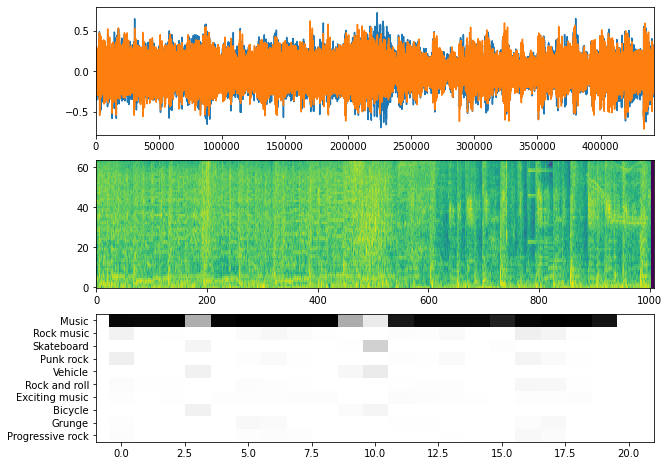

In [28]:
from Utils.audio_plotter import plot_audio_embeddings
import soundfile as sf

wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / sr

# Los siguientes valores son hiperparámetros del modelo, que puede verificarlos en la documentación del mismo
patch_window_seconds: float = 0.96
patch_hop_seconds: float = 0.48

plot_audio_embeddings(scores, embeddings, spectrogram, waveform, class_names, patch_window_seconds, patch_hop_seconds)

## Utilizando YAMNet con transferencia de aprendizaje

<div class="admonition warning">PRECAUCIÓN 😱: El tema presentado en esta sección está clasificado como avanzado. El entendimiento de este contenido es totalmente opcional.</div>

En el caso anterior, utilizamos el modelo completo de YAMNet para resolver el problema. Sin embargo, podemos aplicar transferencia de aprendizaje para utilizar este modelo en el contexto de otro problema. Por ejemplo, el siguiente código utiliza los embeddings generados por YAMNet para resolver un problema de clasificación binaria.

In [30]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

transfer_model = tf.keras.models.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/yamnet/1', trainable=False, output_key='Identity_1:0'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



transfer_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

> __¿Que significa `output_key='Identity_1:0'`__? El modelo YAMNet retorna 3 diferentes salidas: las predicciones segun el problema de clasificación de AudioSet, los embeddings y el espectograma generado. Sin embargo, nosotros solo necesitamos la salida #2. Si visualizamos las diferentes salidas de este modelo, esta corresponde a la salida que tiene como nombre `Identity_1:0`. El parametro `output_key` nos permite seleccionar una salida en particular de cualquier modelo. Para ver las salidas que tiene disponibles cualquier modelo en TensorFlow hub utilize el método `outputs`.

In [37]:
model.signatures['serving_default'].outputs

[<tf.Tensor 'Identity:0' shape=(None, 521) dtype=float32>,
 <tf.Tensor 'Identity_1:0' shape=(None, 1024) dtype=float32>,
 <tf.Tensor 'Identity_2:0' shape=(None, 64) dtype=float32>]